In [128]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sp 
import statsmodels.stats as stats
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


In [2]:
train_16 = pd.read_csv("../Data/train_2016_v2.csv")
# train_17 = pd.read_csv("../Data/train_2017.csv")
properties_16 = pd.read_csv("../Data/properties_2016.csv")
# properties_17 = pd.read_csv("../Data/properties_2017.csv")
# sample_sub = pd.read_csv('../Data/sample_submission.csv')

/Users/MAC/.pyenv/versions/anaconda3-5.0.1/envs/python_ana/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(train_16.dtypes)
print(train_16.transactiondate.values[:3])
train_16.tail()

parcelid             int64
logerror           float64
transactiondate     object
dtype: object
['2016-01-01' '2016-01-01' '2016-01-01']


,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


** transaction counts by transactiondate **

In [29]:
train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).agg(np.mean).reset_index().tail()

,transactiondate,logerror
347,2016-12-26,0.041100
348,2016-12-27,0.018247
349,2016-12-28,-0.002958
350,2016-12-29,0.022229
351,2016-12-30,0.044227


In [31]:
train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).size().reset_index(name="counts").tail()

,transactiondate,counts
347,2016-12-26,15
348,2016-12-27,51
349,2016-12-28,78
350,2016-12-29,117
351,2016-12-30,94


In [111]:
# 월별로 카운트와 평균, 최대, 최소 logerror를 출력 
logerrorbytransactiondate = train_16[["logerror", 'transactiondate']].groupby(np.array([x[:7] for x in train_16.transactiondate]),\
                                                  axis=0).agg([np.mean, np.max, np.min, np.std]).reset_index()
logerrorbytransactiondate.columns = ['y_month', 'mean', 'max', 'min', 'std']
logerrorbytransactiondate.tail()

,y_month,mean,max,min,std
7,2016-08,0.011573,3.436,-4.6050,0.161429
8,2016-09,0.016255,2.762,-1.7370,0.150357
9,2016-10,0.016342,1.749,-1.6050,0.134488
10,2016-11,0.014510,3.443,-0.9943,0.139693
11,2016-12,0.019122,2.387,-4.5100,0.189896


In [112]:
transaction_count_by_month = train_16[["logerror", 'transactiondate']].groupby(np.array([x[:7] for x in train_16.transactiondate]),\
                                                  axis=0).size().reset_index(name="count")
transaction_count_by_month.rename(columns={"index" : "y_month"}, inplace=True)
transaction_by_month = pd.merge(transaction_count_by_month, logerrorbytransactiondate, on="y_month")
del transaction_count_by_month
del logerrorbytransactiondate
transaction_by_month

,y_month,count,mean,max,min,std
0,2016-01,6556,0.015870,3.018,-4.6050,0.171525
1,2016-02,6333,0.016082,4.737,-2.9760,0.198599
2,2016-03,8652,0.009867,3.115,-2.3650,0.172171
3,2016-04,9311,0.006605,4.520,-2.3750,0.166560
4,2016-05,9961,0.006926,3.289,-2.3230,0.150861
5,2016-06,10922,0.007172,2.485,-2.3650,0.151433
6,2016-07,9947,0.011687,3.250,-2.6880,0.151663
7,2016-08,10476,0.011573,3.436,-4.6050,0.161429
8,2016-09,9575,0.016255,2.762,-1.7370,0.150357
9,2016-10,4977,0.016342,1.749,-1.6050,0.134488


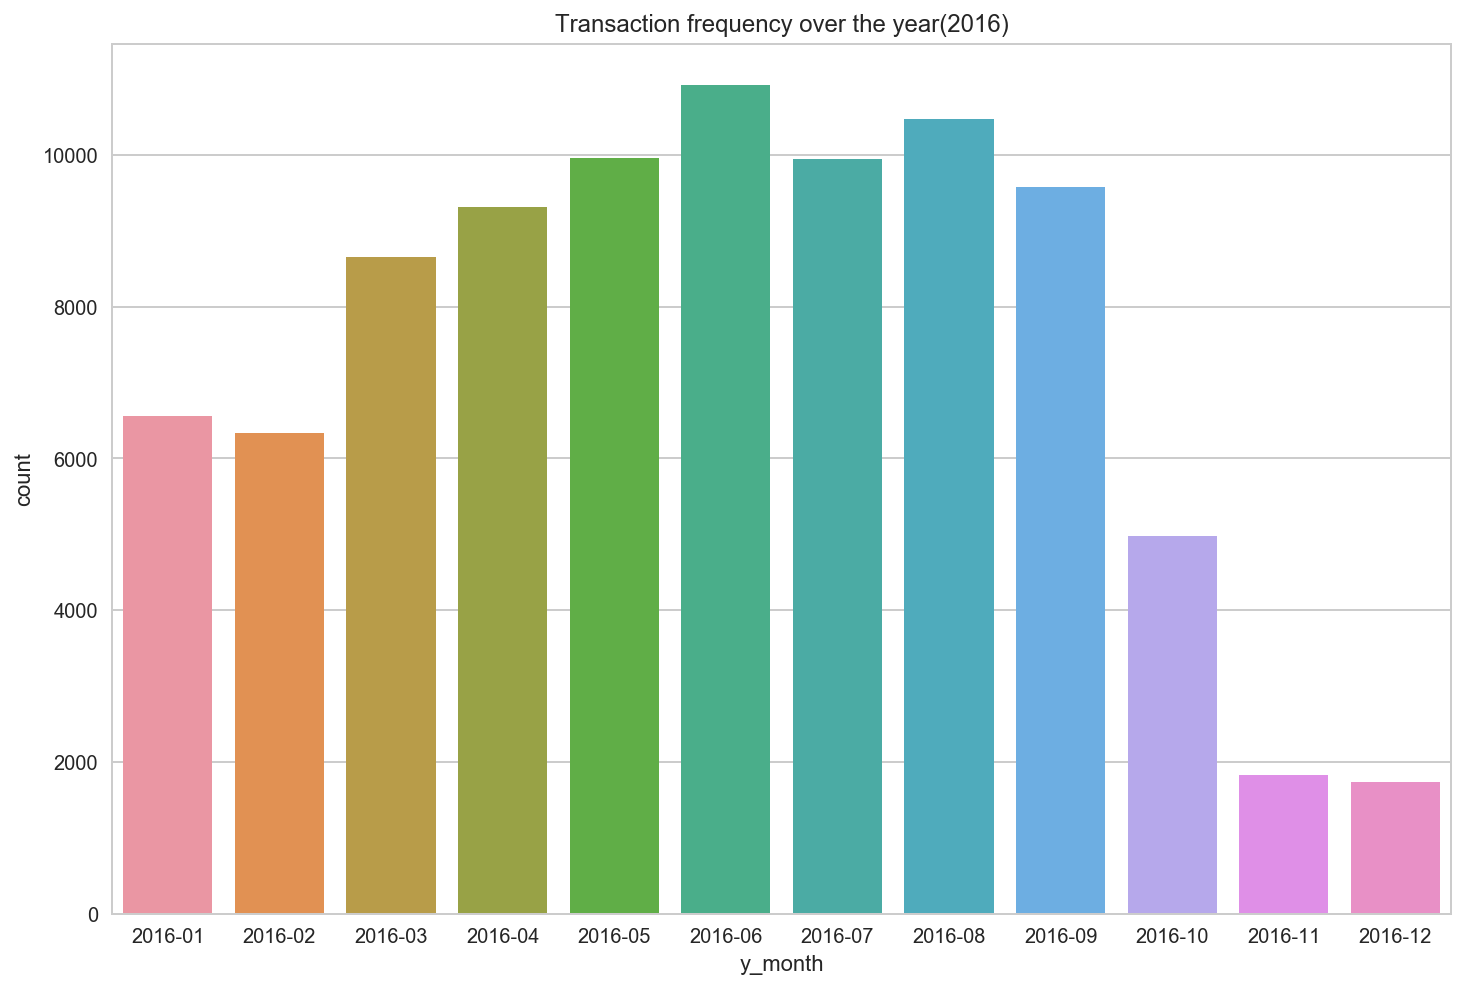

In [129]:
plt.figure(figsize=(12, 8))
plt.title("Transaction frequency over the year(2016)")
sns.barplot(transaction_by_month['y_month'], trasaction_by_month['count'])
plt.show()
# 5, 6, 7, 8월에 transaction 이 많다. 
# 월별로 transaction frequency에 차이가 있다고 할 만 한가? -> 여러 해의 데이터가 필요하기 때문에 2016년 한 해 만으로는 검증하기 힘들다. 

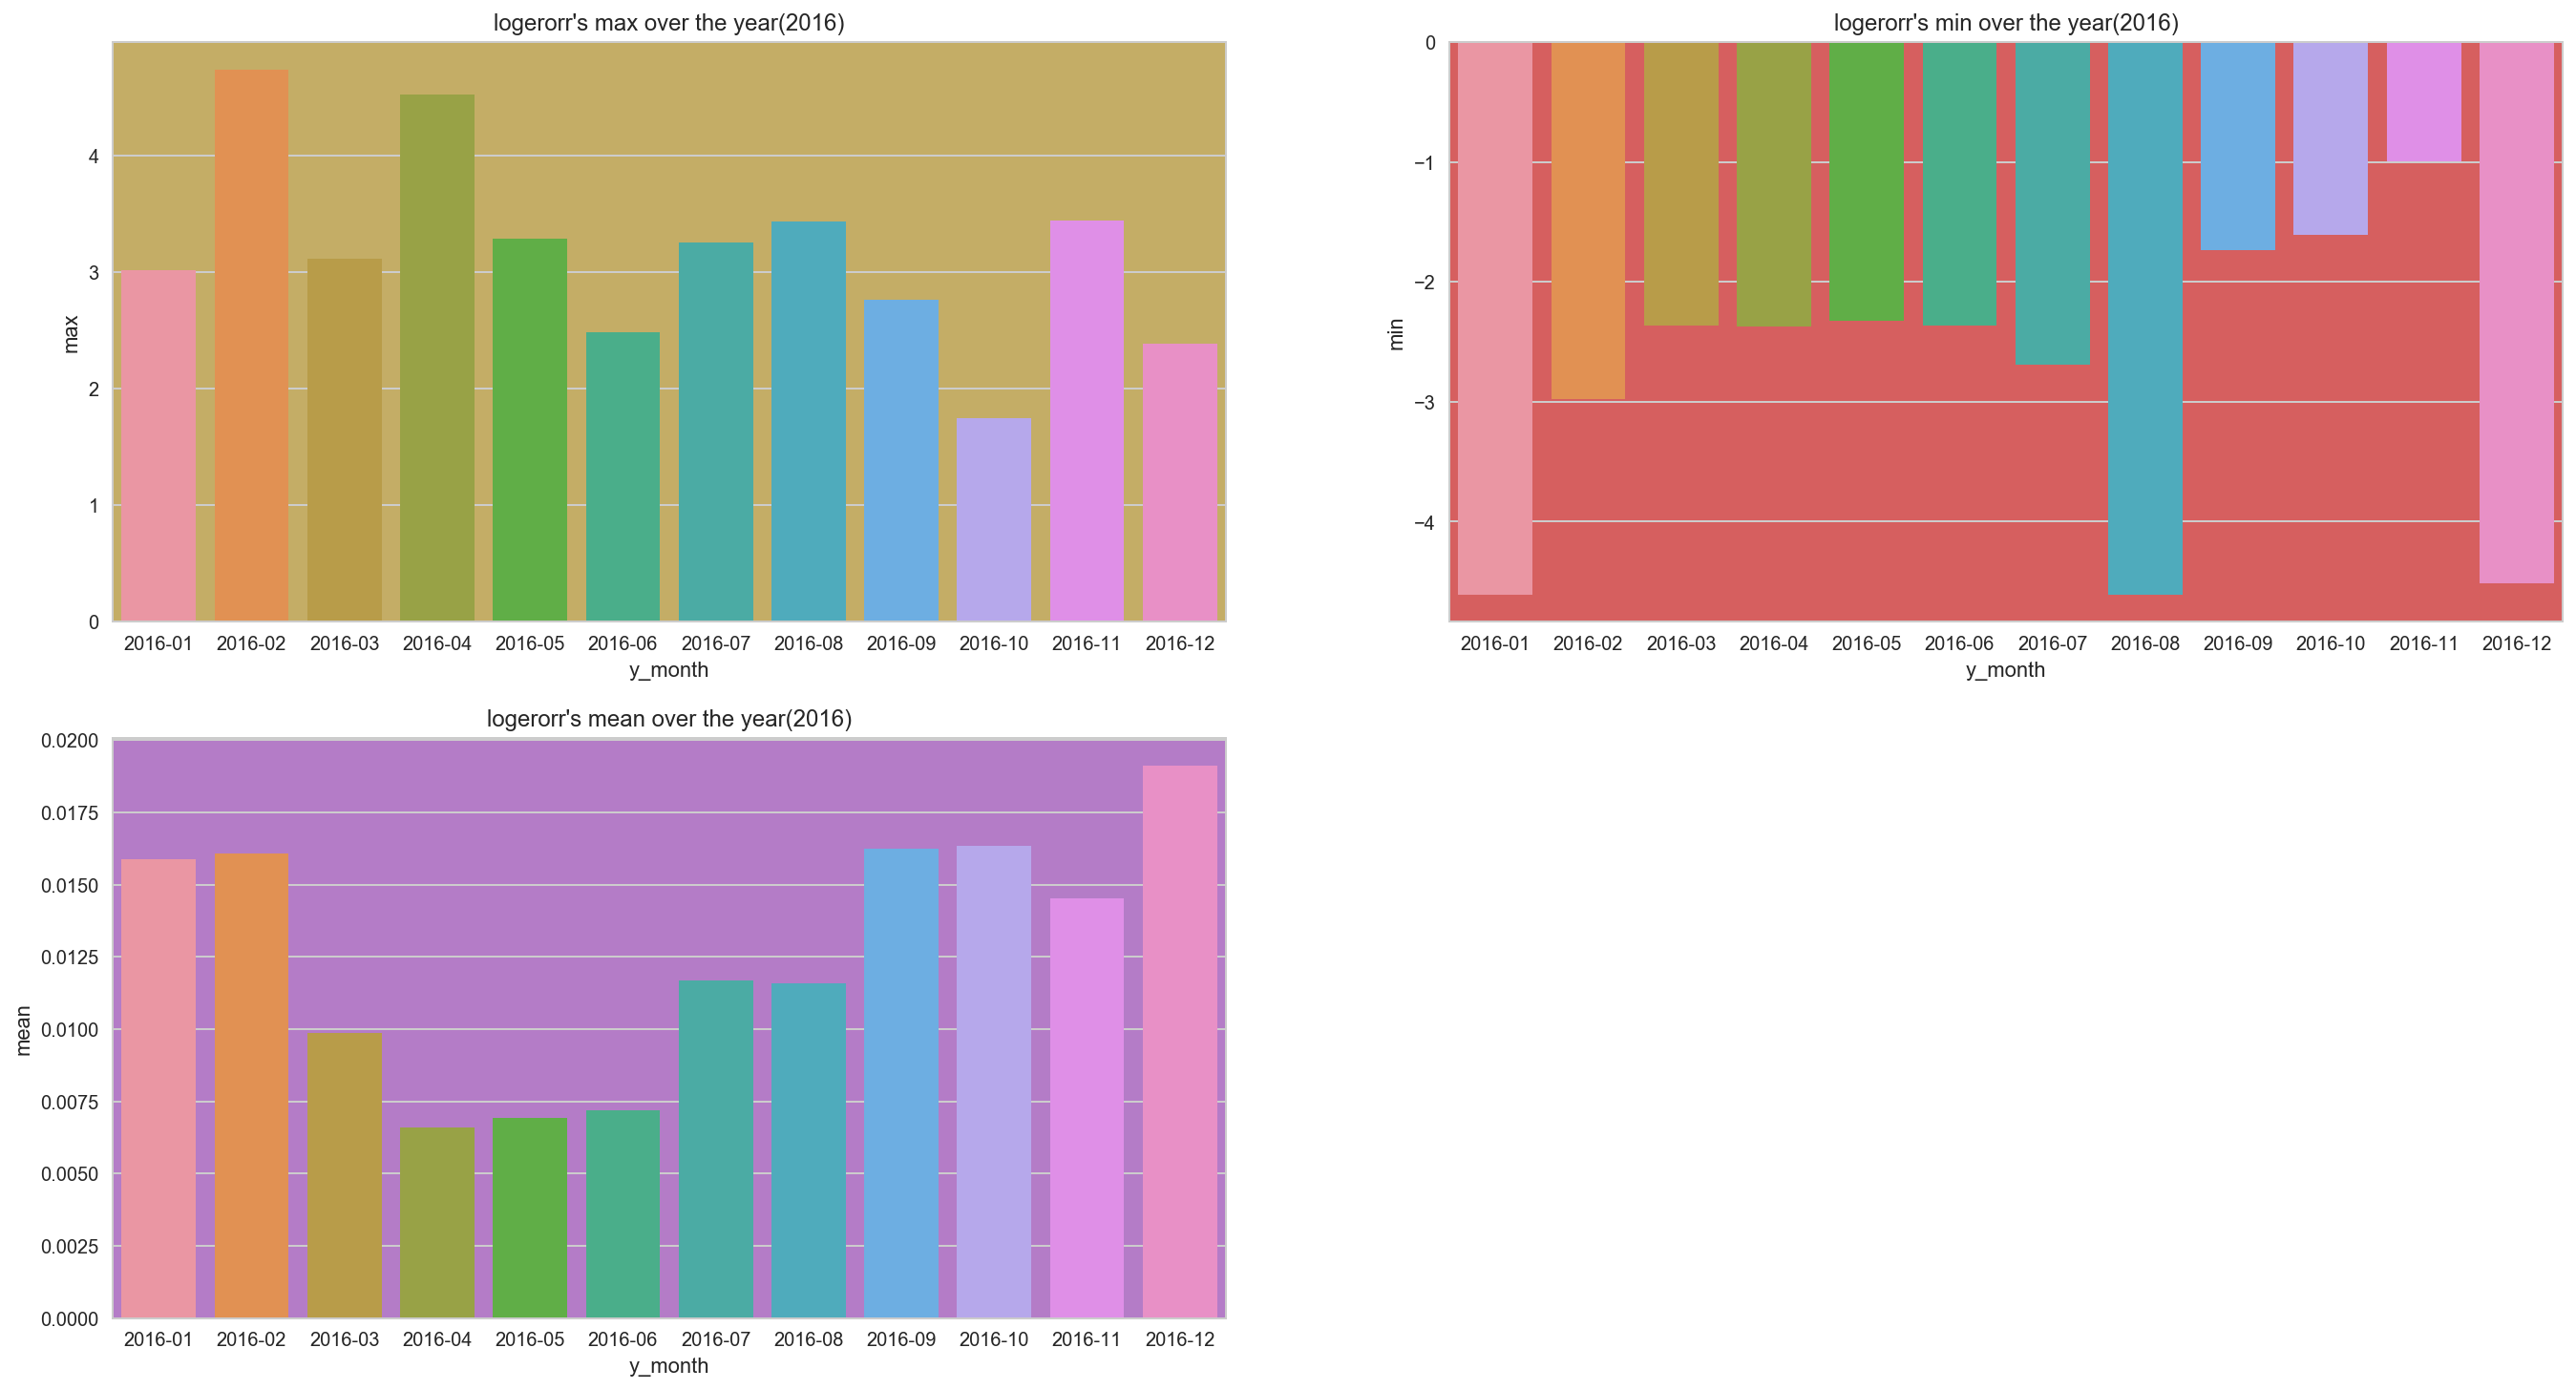

In [130]:
# f, ax = plt.subplots(figsize=(6, 15))

plt.rcParams["figure.figsize"] = (23, 19)
plt.subplot(3, 2, 1, facecolor='y')
plt.title("logerorr's max over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['max'])
plt.subplot(3, 2, 2, facecolor='r')
plt.title("logerorr's min over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['min'])
plt.subplot(3, 2, 3, facecolor='m')
plt.title("logerorr's mean over the year(2016)")
sns.barplot(transaction_by_month['y_month'], transaction_by_month['mean'])
# # 표준편차가 평균보다 훨씬 커서 그래프로 표현이 잘 안된다. 
# plt.errorbar(transaction_by_month['y_month'], transaction_by_month['mean'], transaction_by_month['std'],  marker='^')
plt.show()

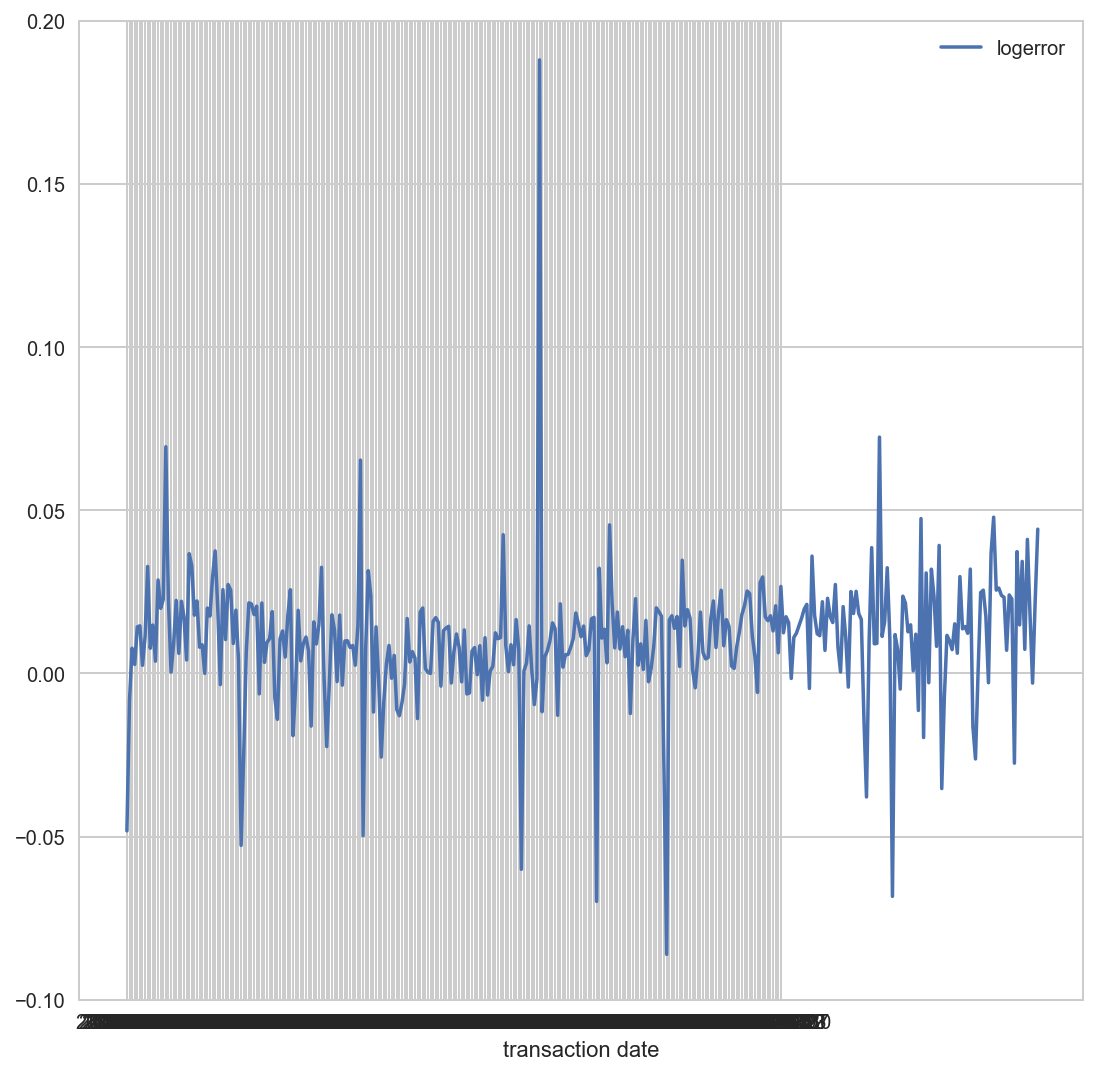

In [131]:
train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).agg(np.mean).reset_index().plot(figsize=(9, 9))
plt.xlabel("transaction date")
_low = np.percentile(train_16.logerror, 1)
_high = np.percentile(train_16.logerror, 99)
plt.ylim((-0.10, 0.20))

potentially_outliers = np.array([x[1:] for x in train_16.values if x[1] < _low or x[1] > _high])
plt.scatter(potentially_outliers[:, 1], potentially_outliers[:, 0], marker='o', c="r", alpha=0.5, s=5)

In [130]:
frequency_by_date = train_16[["logerror", 'transactiondate']].groupby('transactiondate', axis=0).size().reset_index(name='counts')
frequency_by_date

In [27]:
train_16["logerror"].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

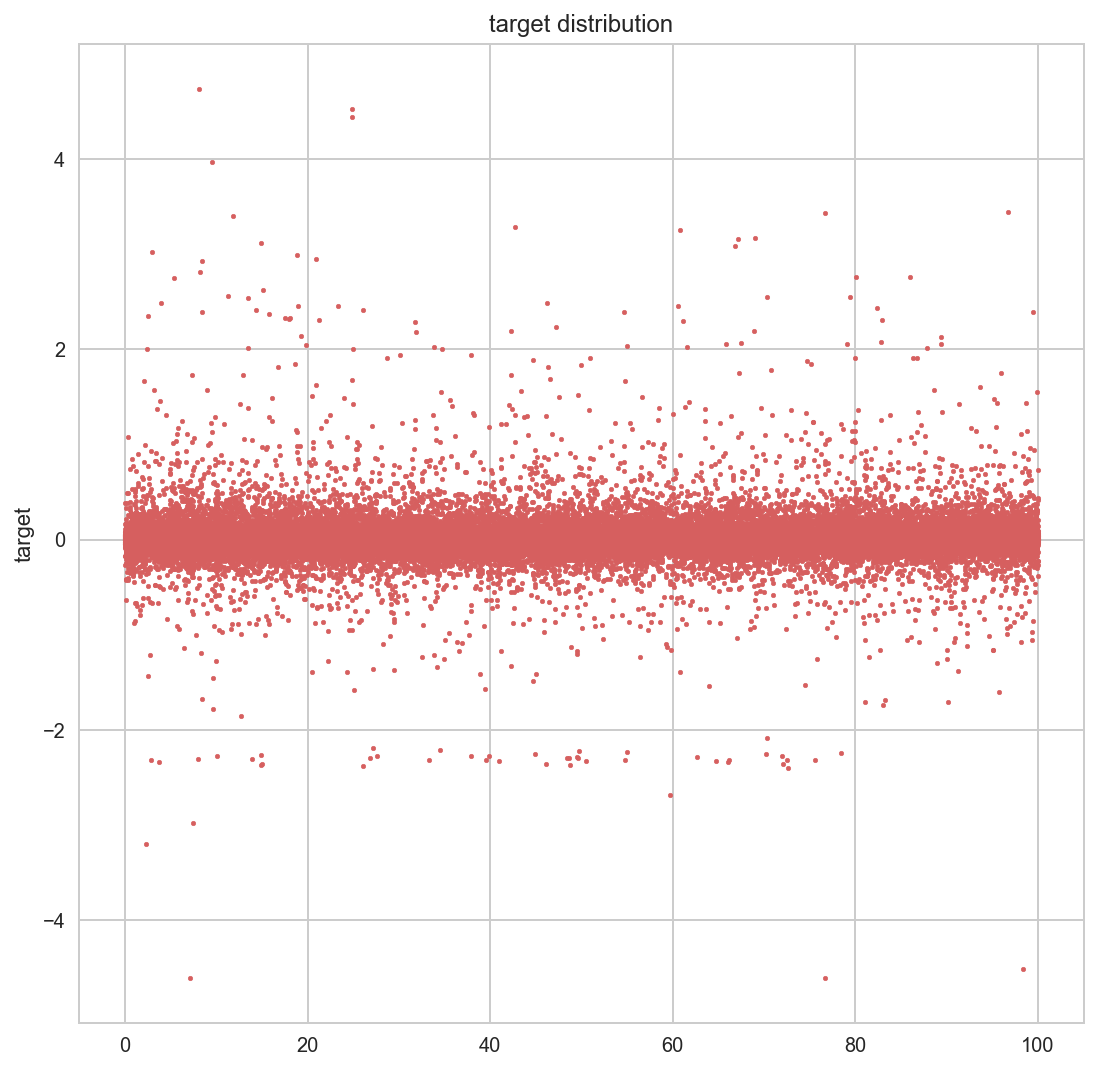

In [132]:
plt.figure(figsize=(9, 9))
plt.title("target distribution")
plt.ylabel("target")
plt.scatter(np.linspace(0, 100, len(train_16)), train_16.logerror,c='r', s=5)

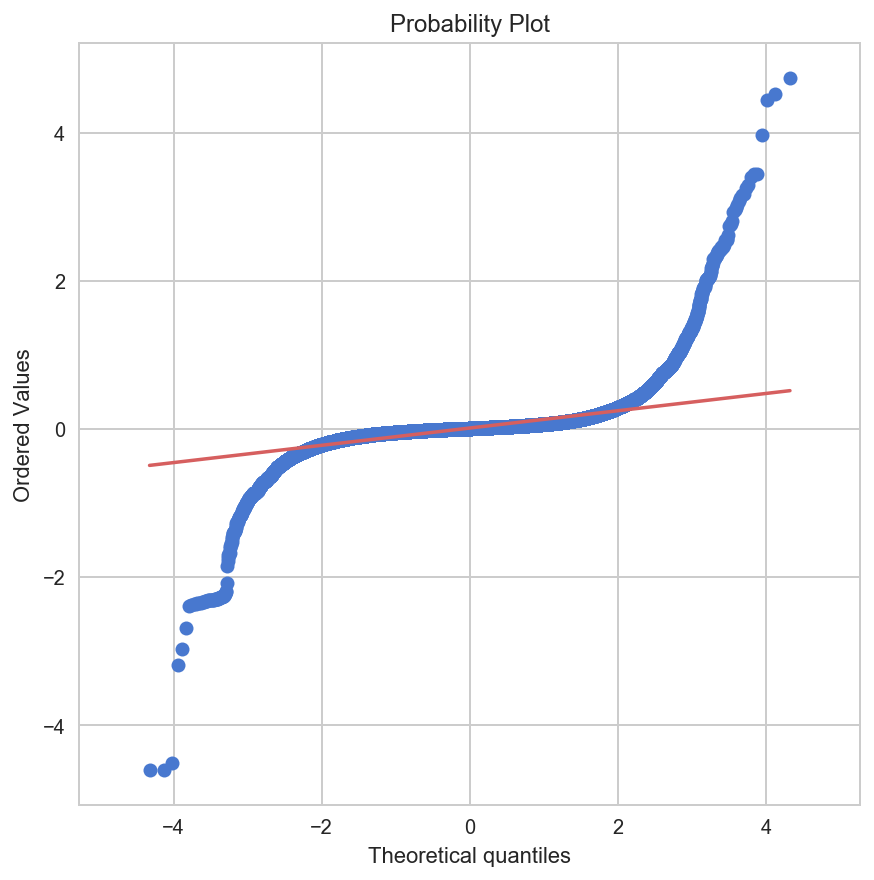

In [133]:
# train's logerror follows 
# qq plot & normality test 

plt.figure(figsize=(7, 7))
sp.stats.probplot(train_16.logerror, plot=plt)
plt.axis("equal")
plt.show()

In [19]:
# normality test 
print("omnibus test")
print(stats.stattools.omni_normtest(train_16.logerror))
print("\njarque_bera test\n 'test statistics', p-value")
print(stats.stattools.jarque_bera(train_16.logerror)[:2])
print("\nKolmogorov-Smirnov test\n 'test statistics', p-value")
print(stats.diagnostic.kstest_normal(train_16.logerror))

# logerror doesn't follow normal distribution -> need to check null hypothesis 

omnibus test
NormaltestResult(statistic=66168.2675135686, pvalue=0.0)

jarque_bera test
 'test statistics', p-value
(64984381.32242768, 0.0)

Kolmogorov-Smirnov test
 'test statistics', p-value
(0.21846846471941828, 0.0)


In [3]:
train_16.describe()

,parcelid,logerror
count,9.027500e+04,90275.000000
mean,1.298466e+07,0.011457
std,2.504510e+06,0.161079
min,1.071174e+07,-4.605000
25%,1.155950e+07,-0.025300
50%,1.254734e+07,0.006000
75%,1.422755e+07,0.039200
max,1.629608e+08,4.737000


In [4]:
print(train_16.dtypes)
train_17.tail()

parcelid             int64
logerror           float64
transactiondate     object
dtype: object


,parcelid,logerror,transactiondate
77608,10833991,-0.002245,2017-09-20
77609,11000655,0.020615,2017-09-20
77610,17239384,0.013209,2017-09-21
77611,12773139,0.037129,2017-09-21
77612,12826780,0.007204,2017-09-25


In [5]:
print(len(sample_sub))
sample_sub.tail()

2985217


,ParcelId,201610,201611,201612,201710,201711,201712
2985212,168176230,0,0,0,0,0,0
2985213,14273630,0,0,0,0,0,0
2985214,168040630,0,0,0,0,0,0
2985215,168040830,0,0,0,0,0,0
2985216,168040430,0,0,0,0,0,0


In [7]:
# # parcelID of Samplesubmission include in train & test 
# i = 0
# count = 0
# while i < len(sample_sub):
    
#     if sample_sub.ParcelId[i] in train_16.parcelid :
#         i += 1 
#         continue
#     elif sample_sub.ParcelId[i] not in train_17.parcelid:
#         i += 1 
#         continue
#     else : 
#         i += 1 
#         count += 1
# count 


0

In [13]:
print(len(np.unique(properties_16.parcelid)))
properties_16.tail()

2985217


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
properties_17.tail()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,12170430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,11422430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,17203030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,14242830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,12766630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
def missing_percentage(df):
    res = []
    for col in df.columns:
        res.append(1 - len(df["{}".format(col)].dropna()) /\
                   len(df["{}".format(col)]))
    
    return pd.Series(np.array(res), index=df.columns)

def newline(p1, p2):
    import matplotlib.lines as mlines
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

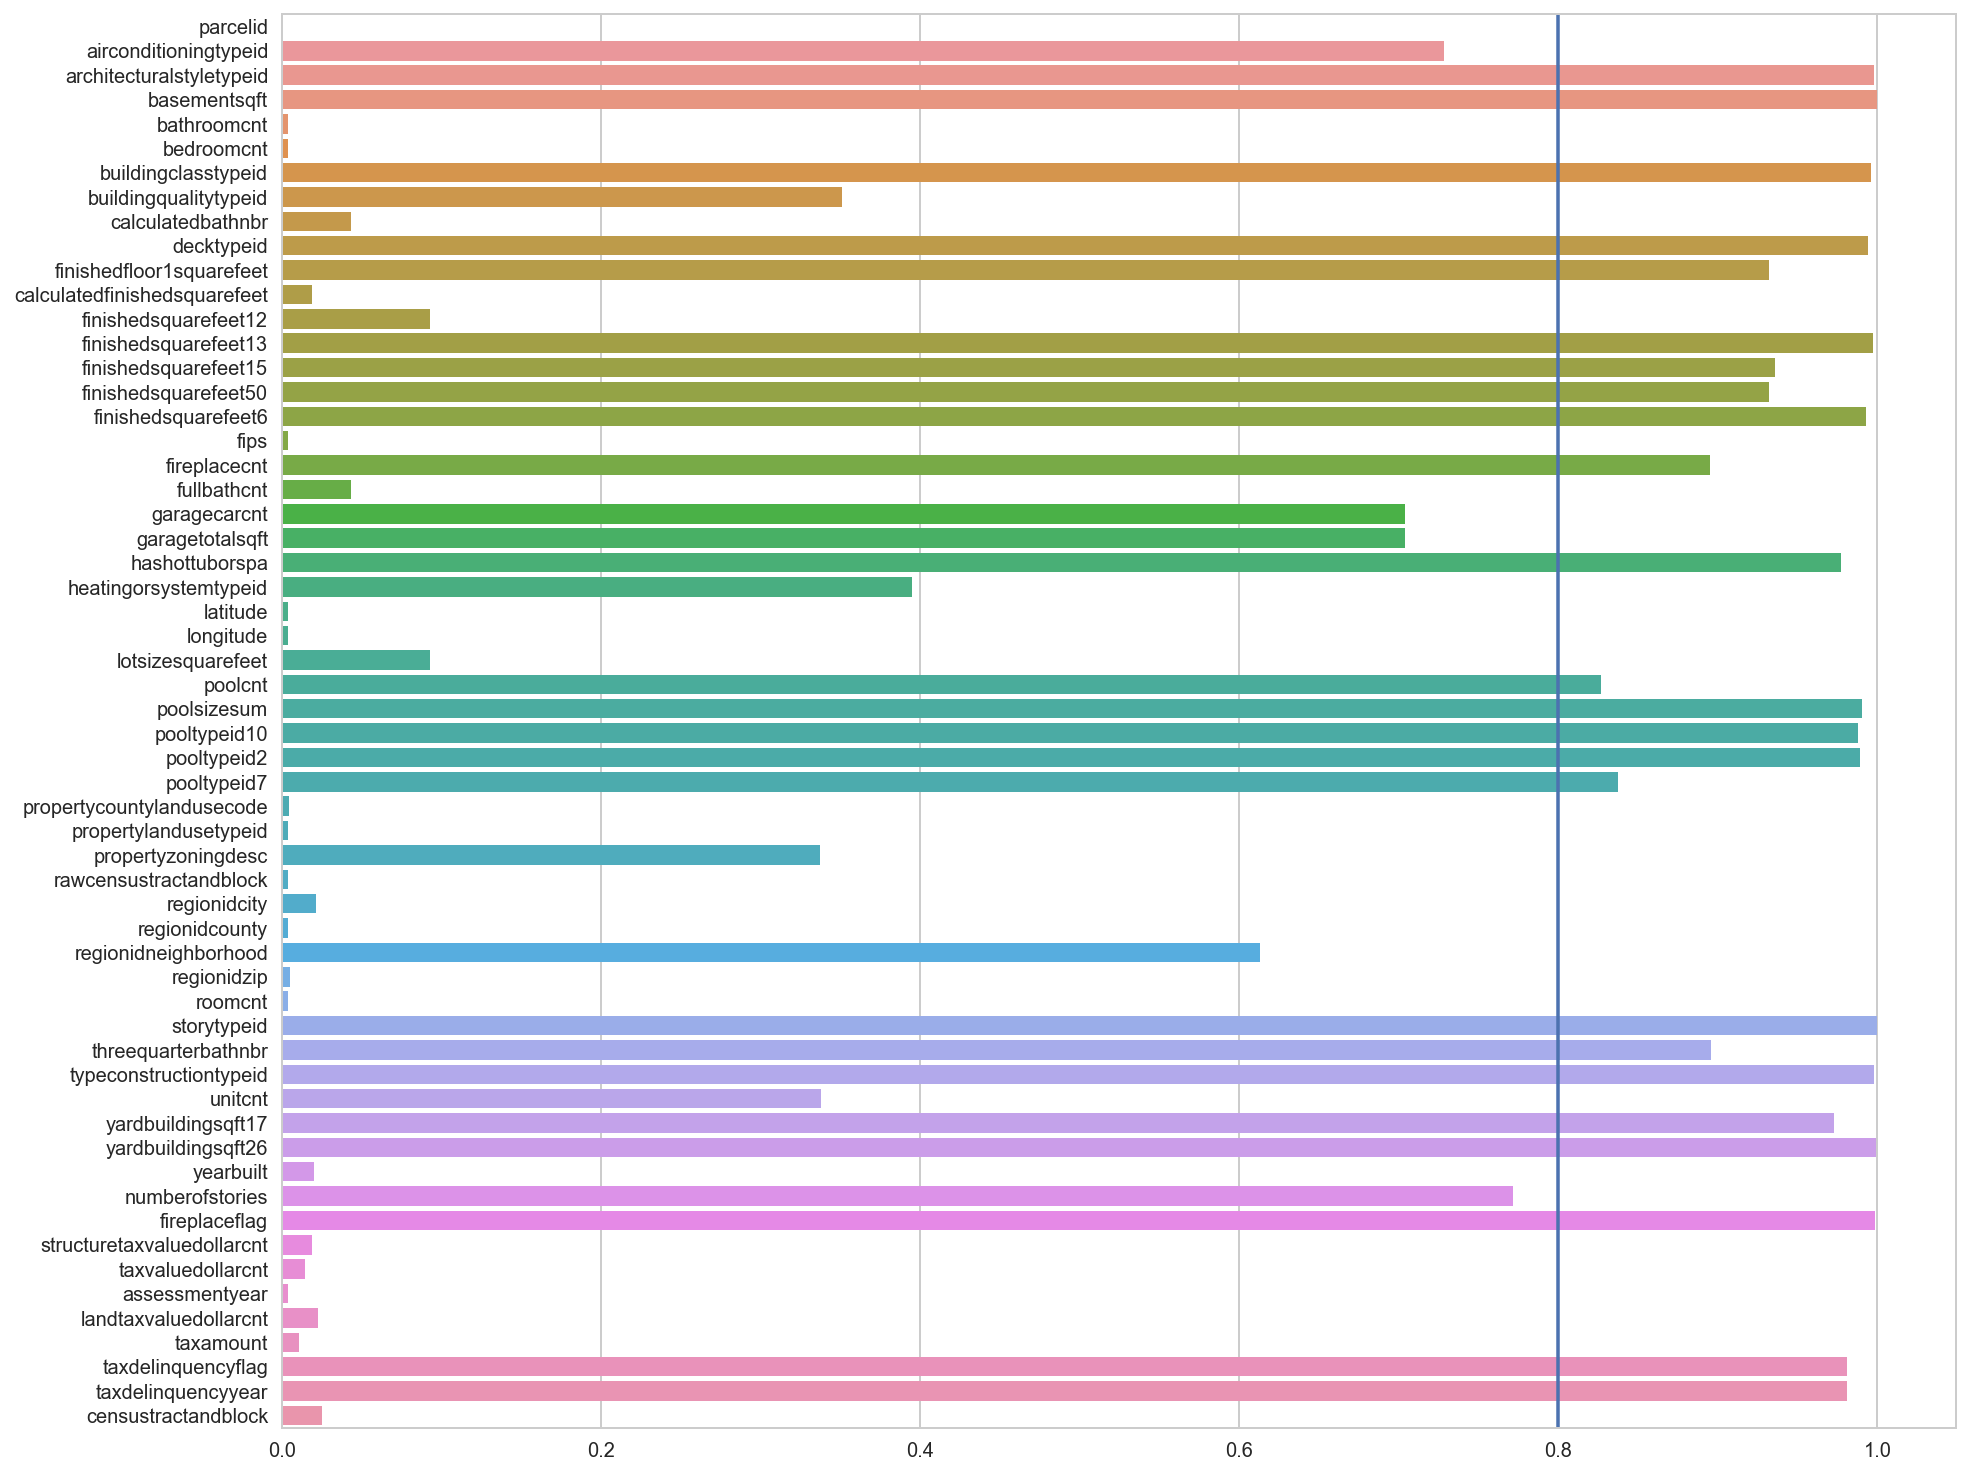

In [163]:
properties_16_missing_ratio = missing_percentage(properties_16)
# properties_16_missing_ratio
plt.figure(figsize=(15, 13))
sns.set_color_codes("pastel")
sns.barplot(properties_16_missing_ratio.values, properties_16_missing_ratio.index)
# plt.legend(ncol=1, loc="lower right", frameon=True)
# plt.set(xlim=(0, 24), ylabel="",
#        xlabel="missing ratio of each columns in properties_16")
# sns.despine(left=True, bottom=True)
# plt.plot([0.8, properties_16_missing_ratio.index[-1]], [0.8, properties_16_missing_ratio.index[0]])

p1 = [0.8,0]
p2 = [0.8,20]
newline(p1,p2) # a border line to demonstrate columns which has over 80% of its amount of missing value
plt.show()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY
26,21.4,8.346,9.416,17.976,18.190,816.21,85.15,MT
18,20.5,7.175,6.765,14.965,20.090,1281.55,194.78,LA
36,19.9,6.368,5.771,18.308,18.706,881.51,178.86,OK
42,19.5,4.095,5.655,15.990,15.795,767.91,155.57,TN
43,19.4,7.760,7.372,17.654,16.878,1004.75,156.83,TX


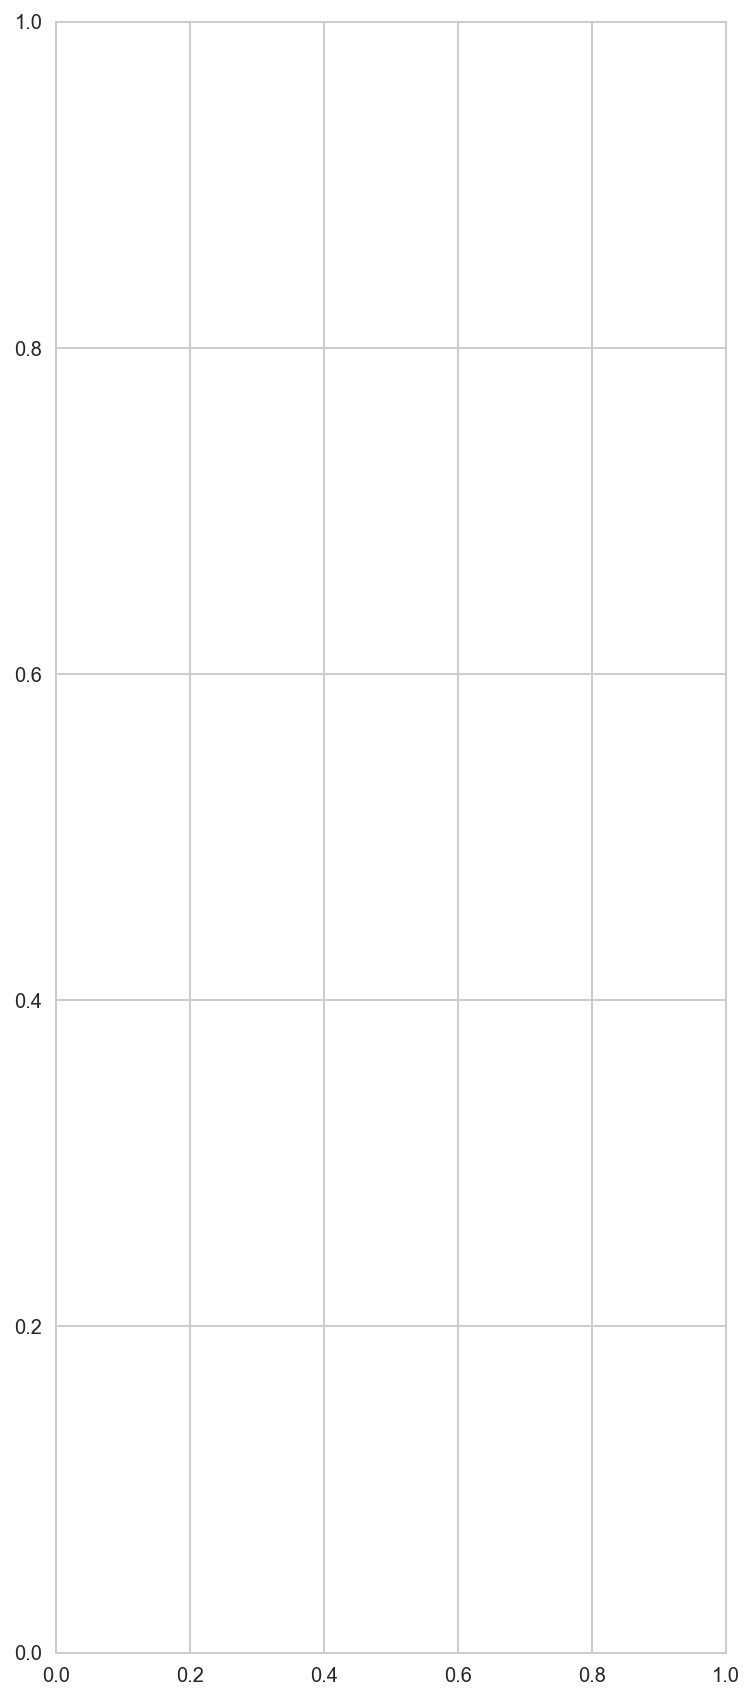

In [139]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
crashes

In [ ]:

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)